# Horse Racing Predictions
## 1. Introduction

This project aims to predict the placements of each horse in a given race. https://www.kaggle.com/datasets/ahmedabdulhamid/horse-racing. 

In this project we will: 
- Clean the horse racing dataset 
- Formulate the problem as a classification problem 
- Perform feature selection 
- Hyperparameter grid search for XGBoost 
- Examine results on embargoed data using a 'show bet' 

## Disclaimer
Sports betting is a complex endeaver, never use a model blindly and always understand the risks associated. I am in no way responsible for any use of this model. 

In [1]:

import pandas as pd 
import numpy as np 
from pathlib import Path
import sklearn 
print(sklearn.__version__)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [22]:
def print_version(module):
    print(module.__name__, module.__version__)

print_version(pd)
print_version(np)
print_version(sklearn)

pandas 2.2.2
numpy 1.26.4
sklearn 1.4.2


## 2. Data loading
This is a rather large dataset (395 columns!). There is a number of columns in which I am not familiar with and I lack the domain knowledge to make determinations. In light of that we will need to reduce columns by two methods:
1. Remove columns with more than 20% missing data 
2. Perform automatic feature selection to prune low impact columns 

In [3]:
data_file = Path.cwd() / 'HorseRacing.csv'
df = pd.read_csv(data_file)

In [4]:
df_float = df.select_dtypes(include=[float])
df_float

,RTR Score,Value Odds,Win Odds,Win Overround,Value %,R10,R9,R8,R7,R6,...,T&S SR wins %,T&S SR wins,T&S SR runs,T&S SR win A/E,T&S SR wins P&L,T&S SR places %,T&S SR places,T&S SR place runs,T&S SR places A/E,T&S SR places P&L
0,185.73,3.95,7.60,101.47,192.55,0.00,0.00,0.00,0.00,0.00,...,20.00,2.0,10.0,0.85,1.77,40.00,4.0,10.0,0.82,-2.82
1,185.63,3.96,5.00,101.47,126.20,0.00,0.00,0.00,0.00,0.00,...,16.96,19.0,112.0,1.09,48.20,36.36,40.0,110.0,0.90,-9.29
2,176.25,5.73,4.80,101.47,83.74,0.00,0.00,0.00,0.00,0.00,...,12.28,7.0,57.0,0.89,-26.42,41.82,23.0,55.0,1.18,13.85
3,172.14,6.80,3.45,101.47,50.70,0.00,0.00,0.00,0.00,124.08,...,24.53,13.0,53.0,1.08,6.83,45.28,24.0,53.0,0.95,-7.04
4,168.21,8.05,7.80,101.47,96.87,0.00,133.61,130.71,137.31,135.33,...,6.25,1.0,16.0,0.36,-11.04,37.50,6.0,16.0,0.86,-3.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,161.50,4.85,6.20,101.53,127.76,112.76,123.18,0.00,116.22,134.32,...,11.76,2.0,17.0,1.00,-4.74,41.18,7.0,17.0,1.21,3.03
13124,158.06,5.67,2.95,101.53,52.04,96.30,110.96,128.03,130.67,118.04,...,10.31,10.0,97.0,0.95,54.08,34.38,33.0,96.0,1.13,25.06
13125,152.14,7.48,30.32,101.53,405.10,129.18,112.25,127.12,117.09,0.00,...,10.00,2.0,20.0,0.89,-8.87,15.00,3.0,20.0,0.46,-12.51
13126,151.66,7.66,18.70,101.53,244.16,118.52,120.68,118.65,130.11,0.00,...,0.00,0.0,13.0,0.00,-13.00,7.69,1.0,13.0,0.60,-9.35


In [5]:
keep_cols = ['Course date', 'Course time', 'Position'] + list(df_float.columns)
df = df[keep_cols]
df

,Course date,Course time,Position,RTR Score,Value Odds,Win Odds,Win Overround,Value %,R10,R9,...,T&S SR wins %,T&S SR wins,T&S SR runs,T&S SR win A/E,T&S SR wins P&L,T&S SR places %,T&S SR places,T&S SR place runs,T&S SR places A/E,T&S SR places P&L
0,"Sunday November 1, 2020",13:35,2,185.73,3.95,7.60,101.47,192.55,0.00,0.00,...,20.00,2.0,10.0,0.85,1.77,40.00,4.0,10.0,0.82,-2.82
1,"Sunday November 1, 2020",13:35,3,185.63,3.96,5.00,101.47,126.20,0.00,0.00,...,16.96,19.0,112.0,1.09,48.20,36.36,40.0,110.0,0.90,-9.29
2,"Sunday November 1, 2020",13:35,1,176.25,5.73,4.80,101.47,83.74,0.00,0.00,...,12.28,7.0,57.0,0.89,-26.42,41.82,23.0,55.0,1.18,13.85
3,"Sunday November 1, 2020",13:35,5,172.14,6.80,3.45,101.47,50.70,0.00,0.00,...,24.53,13.0,53.0,1.08,6.83,45.28,24.0,53.0,0.95,-7.04
4,"Sunday November 1, 2020",13:35,0,168.21,8.05,7.80,101.47,96.87,0.00,133.61,...,6.25,1.0,16.0,0.36,-11.04,37.50,6.0,16.0,0.86,-3.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Sunday June 20th 2021,16:45,5,161.50,4.85,6.20,101.53,127.76,112.76,123.18,...,11.76,2.0,17.0,1.00,-4.74,41.18,7.0,17.0,1.21,3.03
13124,Sunday June 20th 2021,16:45,1,158.06,5.67,2.95,101.53,52.04,96.30,110.96,...,10.31,10.0,97.0,0.95,54.08,34.38,33.0,96.0,1.13,25.06
13125,Sunday June 20th 2021,16:45,4,152.14,7.48,30.32,101.53,405.10,129.18,112.25,...,10.00,2.0,20.0,0.89,-8.87,15.00,3.0,20.0,0.46,-12.51
13126,Sunday June 20th 2021,16:45,6,151.66,7.66,18.70,101.53,244.16,118.52,120.68,...,0.00,0.0,13.0,0.00,-13.00,7.69,1.0,13.0,0.60,-9.35


In [6]:
# Drop columns with more than 20% missing values. 
# Missing values in this dataset are listed as 0.0 
# Except for Position column,  zeros are horses that did not place in the race.
drop_columns = []
for c in df.columns:
    zero_count = (df[c]==0.0).sum()
    percent_zero = zero_count / len(df)
    if percent_zero > 0.20 and c != 'Position':
        print(c, zero_count, percent_zero)
        drop_columns.append(c)


R10 3320 0.2528945764777575
R9 2835 0.2159506398537477
H CSR wins % 8722 0.6643814747105423
H CSR wins 8722 0.6643814747105423
H CSR win A/E 8722 0.6643814747105423
H CSR places % 5024 0.3826934795856185
H CSR places 5056 0.38513101767215113
H CSR places A/E 5024 0.3826934795856185
H TSR wins % 5016 0.3820840950639854
H TSR wins 5016 0.3820840950639854
H TSR win A/E 5016 0.3820840950639854
H DSR wins % 8755 0.6668951858622791
H DSR wins 8755 0.6668951858622791
H DSR win A/E 8755 0.6668951858622791
H DSR places % 4953 0.3772851919561243
H DSR places 4976 0.37903717245581964
H DSR places A/E 4953 0.3772851919561243
H DTSR wins % 9158 0.697592931139549
H DTSR wins 9158 0.697592931139549
H DTSR win A/E 9158 0.697592931139549
H DTSR places % 5381 0.4098872638634979
H DTSR places 5422 0.41301035953686777
H DTSR places A/E 5381 0.4098872638634979
H CDSR wins % 9293 0.7078762949421085
H CDSR wins 9293 0.7078762949421085
H CDSR win A/E 9293 0.7078762949421085
H CDSR places % 6329 0.482099329677

In [7]:
df = df.drop(columns=drop_columns)
df

,Course date,Course time,Position,RTR Score,Value Odds,Win Odds,Win Overround,Value %,R8,R7,...,J&S SR place runs,J&S SR places A/E,J&S SR places P&L,T&S SR runs,T&S SR wins P&L,T&S SR places %,T&S SR places,T&S SR place runs,T&S SR places A/E,T&S SR places P&L
0,"Sunday November 1, 2020",13:35,2,185.73,3.95,7.60,101.47,192.55,0.00,0.00,...,8.0,0.99,-0.50,10.0,1.77,40.00,4.0,10.0,0.82,-2.82
1,"Sunday November 1, 2020",13:35,3,185.63,3.96,5.00,101.47,126.20,0.00,0.00,...,40.0,0.76,-8.48,112.0,48.20,36.36,40.0,110.0,0.90,-9.29
2,"Sunday November 1, 2020",13:35,1,176.25,5.73,4.80,101.47,83.74,0.00,0.00,...,27.0,1.15,10.89,57.0,-26.42,41.82,23.0,55.0,1.18,13.85
3,"Sunday November 1, 2020",13:35,5,172.14,6.80,3.45,101.47,50.70,0.00,0.00,...,42.0,1.14,8.90,53.0,6.83,45.28,24.0,53.0,0.95,-7.04
4,"Sunday November 1, 2020",13:35,0,168.21,8.05,7.80,101.47,96.87,130.71,137.31,...,10.0,0.79,-3.21,16.0,-11.04,37.50,6.0,16.0,0.86,-3.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Sunday June 20th 2021,16:45,5,161.50,4.85,6.20,101.53,127.76,0.00,116.22,...,1.0,3.83,2.83,17.0,-4.74,41.18,7.0,17.0,1.21,3.03
13124,Sunday June 20th 2021,16:45,1,158.06,5.67,2.95,101.53,52.04,128.03,130.67,...,29.0,1.39,28.86,97.0,54.08,34.38,33.0,96.0,1.13,25.06
13125,Sunday June 20th 2021,16:45,4,152.14,7.48,30.32,101.53,405.10,127.12,117.09,...,194.0,1.10,6.84,20.0,-8.87,15.00,3.0,20.0,0.46,-12.51
13126,Sunday June 20th 2021,16:45,6,151.66,7.66,18.70,101.53,244.16,118.65,130.11,...,29.0,1.10,2.83,13.0,-13.00,7.69,1.0,13.0,0.60,-9.35


In [8]:
for c in df.columns[3:]:
    df.loc[:, c].replace(0.0, df[c].mean(), inplace=True)
df

/tmp/ipykernel_125291/896944456.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:, c].replace(0.0, df[c].mean(), inplace=True)


,Course date,Course time,Position,RTR Score,Value Odds,Win Odds,Win Overround,Value %,R8,R7,...,J&S SR place runs,J&S SR places A/E,J&S SR places P&L,T&S SR runs,T&S SR wins P&L,T&S SR places %,T&S SR places,T&S SR place runs,T&S SR places A/E,T&S SR places P&L
0,"Sunday November 1, 2020",13:35,2,185.73,3.95,7.60,101.47,192.55,96.324455,99.64318,...,8.0,0.990000,-0.50,10.0,1.77,40.00,4.0,10.0,0.82,-2.82
1,"Sunday November 1, 2020",13:35,3,185.63,3.96,5.00,101.47,126.20,96.324455,99.64318,...,40.0,0.760000,-8.48,112.0,48.20,36.36,40.0,110.0,0.90,-9.29
2,"Sunday November 1, 2020",13:35,1,176.25,5.73,4.80,101.47,83.74,96.324455,99.64318,...,27.0,1.150000,10.89,57.0,-26.42,41.82,23.0,55.0,1.18,13.85
3,"Sunday November 1, 2020",13:35,5,172.14,6.80,3.45,101.47,50.70,96.324455,99.64318,...,42.0,1.140000,8.90,53.0,6.83,45.28,24.0,53.0,0.95,-7.04
4,"Sunday November 1, 2020",13:35,0,168.21,8.05,7.80,101.47,96.87,130.710000,137.31000,...,10.0,0.790000,-3.21,16.0,-11.04,37.50,6.0,16.0,0.86,-3.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,Sunday June 20th 2021,16:45,5,161.50,4.85,6.20,101.53,127.76,96.324455,116.22000,...,1.0,3.830000,2.83,17.0,-4.74,41.18,7.0,17.0,1.21,3.03
13124,Sunday June 20th 2021,16:45,1,158.06,5.67,2.95,101.53,52.04,128.030000,130.67000,...,29.0,1.390000,28.86,97.0,54.08,34.38,33.0,96.0,1.13,25.06
13125,Sunday June 20th 2021,16:45,4,152.14,7.48,30.32,101.53,405.10,127.120000,117.09000,...,194.0,1.100000,6.84,20.0,-8.87,15.00,3.0,20.0,0.46,-12.51
13126,Sunday June 20th 2021,16:45,6,151.66,7.66,18.70,101.53,244.16,118.650000,130.11000,...,29.0,1.100000,2.83,13.0,-13.00,7.69,1.0,13.0,0.60,-9.35


In [9]:
races = list(set(list(df[['Course date', 'Course time']].itertuples(index=False, name=None)))) # get unique races
len(races)

1483

# 3. Data Cleaning 
Pairwise combination 

The only indicator of performance in race that we have access to is the 'Position' column. We can formulate this as a binary classification problem by performing a pairwise combination of each horse in the race and simply picking if horse 1 or horse 2 should have the better position. 

In [10]:
def get_race(df, race_dt):
    race = df.loc[df['Course date'] == race_dt[0]]
    race = race.loc[race['Course time'] == race_dt[1]]
    race = race.loc[race['Position'] >= 1]
    return race

def pairwise_winners(race):
    new_data = [] 
    for i in range(len(race)):
        for j in range(i+1, len(race)):
            horse_1 = race.iloc[i]
            horse_2 = race.iloc[j]
            if horse_1['Position'] < horse_2['Position']:
                winner = 0 
            else:
                winner = 1

            features = race.select_dtypes(include=[float]).columns
            data = {f: horse_1[f] / horse_2[f] for f in features}
            data['winner'] = winner
            new_data.append(data)
    return pd.DataFrame(new_data)

In [11]:

race_num = 10
race_1 = get_race(df, races[race_num])
race_1 = pairwise_winners(race_1)
pd.options.mode.use_inf_as_na = True

for c in race_1.columns:
    race_1[c].fillna(race_1[c].mean(),inplace=True)
race_1

/tmp/ipykernel_125291/3603752709.py:4: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = True
/tmp/ipykernel_125291/3603752709.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  race_1[c].fillna(race_1[c].mean(),inplace=True)


,RTR Score,Value Odds,Win Odds,Win Overround,Value %,R8,R7,R6,R5,R4,...,J&S SR places A/E,J&S SR places P&L,T&S SR runs,T&S SR wins P&L,T&S SR places %,T&S SR places,T&S SR place runs,T&S SR places A/E,T&S SR places P&L,winner
0,1.039533,0.774678,1.054054,1.0,1.360547,0.939232,0.699427,0.788567,0.916355,0.958178,...,0.625592,0.155305,0.405405,-0.174824,2.242516,0.909091,0.405405,1.056604,0.143192,1
1,1.123506,0.456962,0.161324,1.0,0.353208,1.009858,0.839198,0.820324,0.954668,1.069815,...,1.294118,-9.555556,0.394737,-0.153939,1.897268,0.769231,0.405405,1.009009,0.085734,0
2,1.132959,0.431818,0.105192,1.0,0.243888,0.998861,0.853445,1.065908,1.239156,0.955398,...,1.333333,11.466667,0.416667,-0.321339,2.333567,1.000000,0.428571,1.142857,-0.369697,0
3,1.162584,0.362086,0.312000,1.0,0.862571,1.060290,0.724274,0.759813,0.962166,1.357556,...,0.897959,3.185185,1.071429,2.493506,1.555530,1.666667,1.071429,0.925620,-2.301887,1
4,1.261881,0.209397,0.314516,1.0,1.503128,0.968664,0.726481,0.763647,0.971261,0.985728,...,0.468085,0.618705,0.652174,-0.469151,1.555530,1.111111,0.714286,0.666667,0.159895,0
5,1.080779,0.589873,0.153051,1.0,0.259607,1.075196,1.199836,1.040271,1.041810,1.116509,...,2.068627,-61.527778,0.973684,0.880537,0.846044,0.846154,1.000000,0.954955,0.598735,0
6,1.089873,0.557416,0.099798,1.0,0.179257,1.063488,1.220206,1.351702,1.352266,0.997099,...,2.131313,73.833333,1.027778,1.838075,1.040602,1.100000,1.057143,1.081633,-2.581818,0
7,1.118371,0.467402,0.296000,1.0,0.633988,1.128891,1.035525,0.963536,1.049992,1.416809,...,1.435374,20.509259,2.642857,-14.262987,0.693654,1.833333,2.642857,0.876033,-16.075472,0
8,1.213892,0.270302,0.298387,1.0,1.104797,1.031336,1.038680,0.968397,1.059918,1.028752,...,0.748227,3.983813,1.608696,2.683568,0.693654,1.222222,1.761905,0.630952,1.116645,0
9,1.008414,0.944976,0.652057,1.0,0.690494,0.989110,1.016977,1.299375,1.297996,0.893050,...,1.030303,-1.200000,1.055556,2.087448,1.229961,1.300000,1.057143,1.132653,-4.312121,1


### Building the training set 
Each row of the new dataset will be a comparison between two horses that competed in a race against each other. This is a pairwise comparison that will compare each horse in the race to every other horse. 

Two important notes:
1. By inversing the race order, the position of horse_1 and horse_2 are swapped, this creates a balanced dataset to avoid a bias towards horse_1 or horse_2 
2. Since we are performing feature selection and hyperparameter selection, 500 races are being witheld as test data that will not be evaluated until the end of this project. This is to avoid any accidental overfitting 


In [12]:
# Inversing the race rows creates a balanced dataset
import copy 
dataframes = []
for race_dt in races[:-500]:
    race = get_race(df, race_dt)
    inv_race = copy.deepcopy(race)
    race = pairwise_winners(race)
    dataframes.append(race)
    inv_race = inv_race.iloc[::-1]
    inv_race = pairwise_winners(inv_race)
    dataframes.append(inv_race)
    
train_df = pd.concat(dataframes)

In [14]:
train_df

,RTR Score,Value Odds,Win Odds,Win Overround,Value %,R8,R7,R6,R5,R4,...,J&S SR places A/E,J&S SR places P&L,T&S SR runs,T&S SR wins P&L,T&S SR places %,T&S SR places,T&S SR place runs,T&S SR places A/E,T&S SR places P&L,winner
0,1.009004,0.936143,0.628571,1.0,0.671040,0.878930,1.129730,1.207338,0.972186,0.841478,...,1.225490,11.581731,0.298246,1.338753,1.043324,0.311111,0.298246,1.326531,123.538462,1
1,1.014558,0.899387,1.071429,1.0,1.190583,1.416118,1.031806,0.922364,0.976915,1.060675,...,1.077586,-253.578947,3.400000,-4.423881,0.823600,2.800000,3.400000,0.878378,28.678571,1
2,1.032688,0.790723,1.204380,1.0,1.522666,0.883724,0.948022,1.007262,0.871442,0.782312,...,1.168224,8.030000,1.360000,-0.416760,1.286875,1.750000,1.360000,1.287129,10.251064,1
3,1.108912,0.473514,0.485651,1.0,1.025635,1.227726,1.279465,1.207338,1.142010,0.988900,...,0.584112,42.263158,17.000000,7.410000,1.296539,1.169064,34.000000,1.313649,-48.180000,1
4,1.005505,0.960736,1.704545,1.0,1.774236,1.611184,0.913321,0.763965,1.004864,1.260490,...,0.879310,-21.894737,11.400000,-3.304478,0.789400,9.000000,11.400000,0.662162,0.232143,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.890927,2.468750,5.563892,1.0,2.251181,0.865268,0.909361,0.949013,1.240607,0.859277,...,0.818548,-2.645833,1.040000,-0.966261,0.865500,0.900000,1.040000,0.990000,-1.011111,0
6,0.832231,4.133721,13.796512,1.0,3.334366,0.963764,0.878098,0.946658,1.045654,0.839868,...,0.838843,-0.132292,0.382353,-0.965356,1.023655,0.391304,0.382353,1.010204,-0.156089,1
7,0.969002,1.277778,0.679953,1.0,0.531305,0.751478,0.739083,0.889476,1.143360,1.058683,...,0.516129,-2.333333,0.200000,0.108716,0.500000,0.100000,0.200000,0.350000,1.838889,1
8,0.905162,2.139535,1.686047,1.0,0.786949,0.837022,0.713674,0.887269,0.963688,1.034769,...,0.528926,-0.116667,0.073529,0.108614,0.591366,0.043478,0.073529,0.357143,0.283877,1


# 4. Model creation

Now that the dataset has been constructed, the model can be designed and trained. 

XGBoost model was selected for this as it is a robust model that can handle high-dimensional data, and in general quite performant for classification tasks. Other models were not explored, and this may be an area for some improvement. 

## Baseline
A XGBoost model utilizing every available column will be the baseline. Afterwards I will perform feature selection. 

In [15]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
def xgboost_classifier(df, target_column, test_size=0.2, random_state=42):
    # Separate features and target variable
    X = df.drop(target_column, axis=1)
    X = (X - X.min()) / (X.max() - X.min())
    y = df[target_column]
    
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create XGBoost classifier
    model = xgb.XGBClassifier(random_state=random_state)
    
    # Train the classifier
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # cm = confusion_matrix(y_test, y_pred)
    
    return (accuracy, precision, recall, f1), model

In [16]:
cr, xgb_model = xgboost_classifier(train_df, 'winner')

print(cr)

(0.6275275735294118, 0.6319685403654869, 0.623317362537075, 0.6276131403629681)


The baseline model is achieving an accuracy of 62.7% on the test set of 20%. Lets see if complexity can be reduced and performance can be improved

## Feature Selection

Feature selection is performed by the Recurrsive Feature Selection (RFE) algorithm from the scikit-learn library. The goal here is to reduce the amount of features used to a small subset. It is preferable to use a model with less complexity as it is more interpretable and less prone to overfitting. I will be reducing the number of features to 5.

In [17]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

target_column = 'winner'

X = train_df.drop(target_column, axis=1)
X = (X - X.min()) / (X.max() - X.min())
y = train_df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Perform RFE with XGBoost
rfe = RFE(estimator=xgb_model, n_features_to_select=5, step=0.1)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Train the XGBoost model with the selected features
xgb_model.fit(X_train[selected_features], y_train)

# Make predictions on the test set using the selected features
y_pred = xgb_model.predict(X_test[selected_features])

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Selected features: Index(['Win Odds', 'H CDSR place runs', 'H CDSR places P&L',
       'T 14 - day place runs', 'T DSR place runs'],
      dtype='object')
Accuracy: 0.6261488970588235


With reducinng the number of features to 5, the model is able to acheive an accuracy of 62.6%, this is 0.1% less than using the entire feature set. I will be moving forward only using these 5 features as the benefit of reduced complexity outweights the small gain in accuracy. 

The five features are:
- Win Odds: 
- H CDSR place runs: 
- H CDSR places P&L:
- T 14 - day place runs:
- T DSR place runs:

### Pair Plot of Selected Features

A pairplot can be used to visualize any trends among the features in relation to each other. 

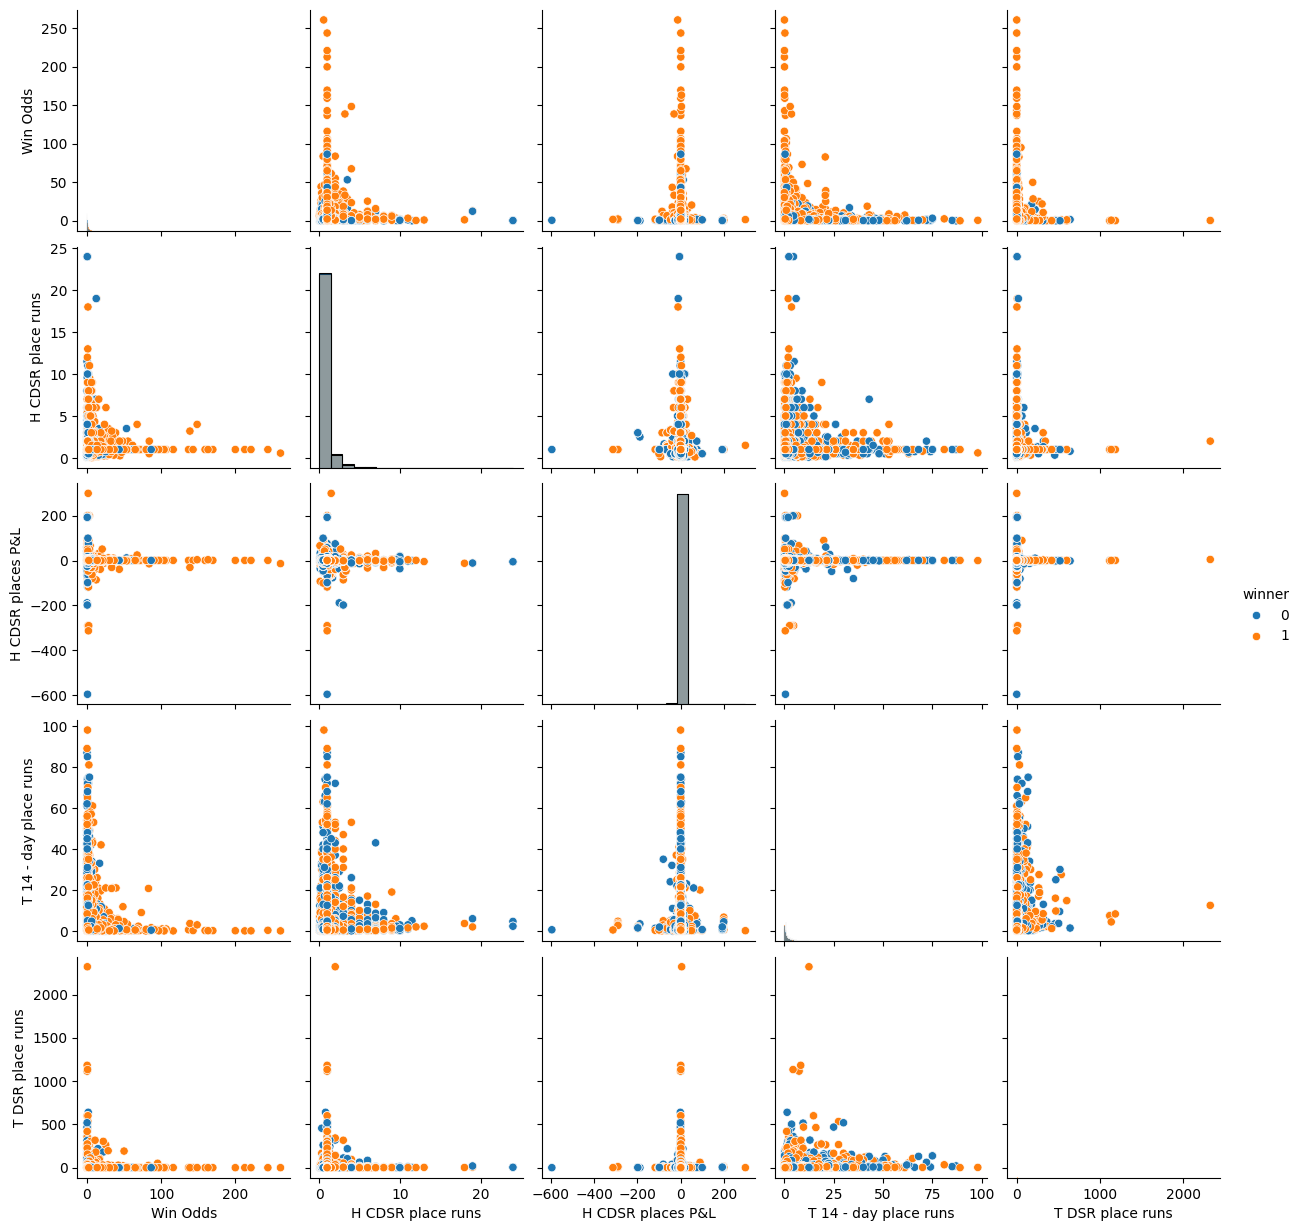

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
cols = [sf for sf in selected_features]
cols +=  ['winner']

sns.pairplot(train_df[cols], hue='winner', diag_kind='hist')

plt.show()


The plots seem to indicate that there are some clusters in which a determination of the winning horse may be, indicating that there may be some underlying trend that can be modeled.

### Grid Search for hyperparameter selection

Here I will simply do a grid search to determine which hyperparameters to use. This is a non-exhaustive search, but it should provide parameters that will improve the performance of the model

In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X = train_df[cols]
target_column = 'winner'

X = X.drop(target_column, axis=1)
X = (X - X.min()) / (X.max() - X.min())
y = train_df[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create an XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best hyperparameters:", best_params)
print("Best score:", best_score)

# Train the XGBoost model with the best hyperparameters
best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the best model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model:", accuracy)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best score: 0.6377972946261734
Accuracy of the best model: 0.6321231617647058


The grid search found parameters that resulted in a 63.2% accuracy score. This is a 0.6% improvement of our model.

## Performance on embargoed data

How does this translate to how we would perform a bet? 

We will see what our chances are on winning a 'show' bet. This is a bet in which we will selecting a horse that we think will finish in one of the first three positions. 

In [20]:
import itertools

def sort_horses(df, model, scaler):
    pairwise_comparisons = [] 
    horse_ids = df.index.unique()
    horse_pairs = list(itertools.combinations(horse_ids, 2)) # all posible pairs 
    features = [c for c in cols if c != 'winner']
    for horse_1, horse_2 in horse_pairs:

        horse_1_df = df.loc[horse_1]
        horse_2_df = df.loc[horse_2]
        data = {f: (horse_1_df[f] / horse_2_df[f] - train_df[f].min()) / (train_df[f].max() - train_df[f].min()) for f in features}

        input_features = pd.DataFrame([data]).to_numpy()
        winner = best_model.predict(input_features)[0]
        if winner == 0:
            pairwise_comparisons.append((horse_1, horse_2))
        else:
            pairwise_comparisons.append((horse_2, horse_1))
    wins = {horse_id: 0 for horse_id in horse_ids}
    for winner, loser in pairwise_comparisons:
        wins[winner] += 1
    sorted_horses = sorted(wins, key=wins.get, reverse=True)
    return sorted_horses
        

In [21]:
results = []
scaler = None
correct = 0 
i = 0
for test_race in races[-500:]:
    race = get_race(df, test_race)
    horses = sort_horses(race, best_model, scaler)
    if len(horses) > 2:
        i += 1
        race = race.sort_values(by='Position', ascending=True)
        top_three_horses = race.index[:3]
        if horses[0] in top_three_horses:
            correct += 1 



print(correct / i)


0.733739837398374


## Conclusion 

From our embargoed data we can expect a 73.37% chance at correctly selecting a winner for a 'show' bet! This may be all that is needed for a profitable betting strategy. This all depends on a reliable risk/reward model. Before running down to the racetrack, please keep in mind that a place bet is one of the easiest to win, and yields the among the lowest return. 

Future work
- Combine with other data sources (Weather/temperature/humidity may lead to intresting insights)
- Compare other models
- Other target variables (Is there a way to treat this as a regression problem? Can time to finish be predicted?)
- Are there scenarios in which the model performs better? (ideal number of horses racing, time of year, race course)


### Disclaimer 
Any use of this code for horse betting places all responsibilty on the user, the author is not responsible for any use of this code